<a href="https://colab.research.google.com/github/shintaroudlotulhanafia/TugasAkhirMultipleStocks/blob/main/HP_TUNING/14_TugasAkhir_Shinta_DRLforMultipleStockTrading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning untuk Jual-Beli Saham (Dari Awal): Jual-beli Banyak Saham 

* **Pytorch Version** 



<a id='0'></a>
# Bagian 1. Pendeskrisian Tugas

Agen DRL dilatih untuk melakukan jual-beli saham. Tugas tersebut dimodelkan sebagai Markov Decision Process (MDP), dengan fungsi dan tujuannya adalah memaksimalkan pengembalian pengembalian kumulatif *(cummulative return)* yang diharapkan.

Definisi state-action-reward pada algoritam DRL kasus kali ini adalah sebagai berikut:

* **State s**: Kondisi atau *state* mewakili persepsi agen tentang lingkungan pasar. Sama seperti *trader* manusia yang menganalisis berbagai informasi, agen juga secara pasif mengamati banyak fitur dan belajar dengan cara berinteraksi dengan lingkungan pasar (biasanya dengan menjalankan ulang data historis).

* **Tindakan atau *action* a**: Ruang aksi mencakup aksi atau tindakan yang dapat dilakukan agen di setiap status atau kondisi. Misalnya, a {−1, 0, 1}, -1 berarti menjual, 0 berarti menahan, dan 1 berarti membeli. Ketika suatu aksi mengoperasikan beberapa saham, maka, a {−k, ..., 1, 0, 1, ..., k}. Misalnya, "Beli
10 saham TLKM" atau "Jual 10 saham TLKM" maka masing-masing nilai a adalah 10 atau -10.

* **Fungsi *reward* atau imbalan r(s, a, s′)**: *Reward* adalah insentif bagi agen untuk mempelajari kebijakan yang lebih baik. Misalnya *reward* dapat berupa perubahan nilai portofolio saat mengambil a pada keadaan s dan tiba pada keadaan baru s', yaitu, r(s, a, s′) = v′-v, v′ mewakili nilai portofolio pada keadaan s′ dan v mewakili nilai portofolio pada keadaan s.

* **Environment atau lingkungan jual-beli**: saham penyusun indeks JII dengan tanggal sesuai periode pengujian yang diatur.


Data untuk studi kasus ini diperoleh dari Yahoo Finance API. Data berisi harga *Open-High-Low-Close* dan *Volume*.

<a id='1'></a>
# Bagian 2. Instalasi Paket Python

<a id='1.1'></a>
## 2.1. Instalasi Paket


In [57]:
# install finrl library
!pip install git+https://github.com/shintaroudlotulhanafia/FinRL.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/shintaroudlotulhanafia/FinRL.git to /tmp/pip-req-build-zvbl7bcd
  Running command git clone -q https://github.com/shintaroudlotulhanafia/FinRL.git /tmp/pip-req-build-zvbl7bcd
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-mwfs6w8v/pyfolio_5652fa9242264620a60d9ce6921b023a
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-mwfs6w8v/pyfolio_5652fa9242264620a60d9ce6921b023a
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-mwfs6w8v/elegantrl_60924520227e4206ad44d334d5be640e
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-mwfs6w8v/elegantrl_60924520227e4206ad44d334d5be640e


<a id='1.2'></a>
## 2.2. Daftar Paket Python
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Impot Paket

In [58]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

<a id='1.4'></a>
## 2.4. Membuat Folder

In [59]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Mengunduh Data

In [60]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2017-12-31'
TRADE_START_DATE = '2018-01-01'
TRADE_END_DATE = '2019-12-20'

In [61]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.JII_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [62]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-05,520.000000,520.000000,485.000000,276.809082,3.0,ADRO.JK,0
1,2009-01-05,957.573608,1049.971069,949.173828,820.693359,158999024.0,ANTM.JK,0
2,2009-01-05,61.000000,70.000000,60.000000,64.386543,95470000.0,BRPT.JK,0
3,2009-01-05,89.000000,94.000000,88.000000,73.513832,41810000.0,CPIN.JK,0
4,2009-01-05,868.023865,868.023865,868.023865,766.323242,4055.0,EXCL.JK,0


<a id='3'></a>
# Bagian 4: Memproses Data

In [63]:
INDICATORS = [
    "macd",
    "rsi_30",
    "cci_30"
]

In [64]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (2759, 8)
Successfully added vix
Successfully added turbulence index


In [65]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [66]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,vix,turbulence
0,2009-01-05,BRPT.JK,61.0,70.0,60.0,64.386543,95470000.0,0.0,0.000000,0.000000,-66.666667,39.080002,0.0
1,2009-01-05,KLBF.JK,81.0,84.0,80.0,63.608841,165165000.0,0.0,0.000000,0.000000,-66.666667,39.080002,0.0
2,2009-01-05,SCMA.JK,16.6,16.6,16.6,8.936809,50.0,0.0,0.000000,0.000000,-66.666667,39.080002,0.0
3,2009-01-05,UNVR.JK,1620.0,1620.0,1560.0,1149.686401,20.0,0.0,0.000000,0.000000,-66.666667,39.080002,0.0
4,2009-01-06,BRPT.JK,66.0,71.0,62.0,60.484325,72175000.0,1.0,-0.087550,0.000000,-66.666667,38.560001,0.0
5,2009-01-06,KLBF.JK,81.0,82.0,80.0,63.608841,44137500.0,1.0,0.000000,0.000000,-66.666667,38.560001,0.0
6,2009-01-06,SCMA.JK,16.4,16.4,16.4,8.829136,87500.0,1.0,-0.002416,0.000000,-66.666667,38.560001,0.0
7,2009-01-06,UNVR.JK,1620.0,1670.0,1600.0,1163.880005,16432500.0,1.0,0.318446,100.000000,66.666667,38.560001,0.0
8,2009-01-07,BRPT.JK,63.0,70.0,61.0,61.459877,80160000.0,2.0,-0.081304,20.547897,-100.000000,43.389999,0.0
9,2009-01-07,KLBF.JK,81.0,83.0,80.0,63.608841,166020000.0,2.0,0.000000,20.547897,0.000000,43.389999,0.0


In [67]:
processed_full.nunique()

date           2652
tic               4
open           2015
high           2064
low            2066
close          4200
volume         9087
day               5
macd          10602
rsi_30         9078
cci_30        10597
vix            1441
turbulence     2399
dtype: int64

In [68]:
processed_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10608 entries, 0 to 15999
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        10608 non-null  object 
 1   tic         10608 non-null  object 
 2   open        10608 non-null  float64
 3   high        10608 non-null  float64
 4   low         10608 non-null  float64
 5   close       10608 non-null  float64
 6   volume      10608 non-null  float64
 7   day         10608 non-null  float64
 8   macd        10608 non-null  float64
 9   rsi_30      10608 non-null  float64
 10  cci_30      10608 non-null  float64
 11  vix         10608 non-null  float64
 12  turbulence  10608 non-null  float64
dtypes: float64(11), object(2)
memory usage: 1.1+ MB


In [69]:
print(processed_full['tic'].unique())

['BRPT.JK' 'KLBF.JK' 'SCMA.JK' 'UNVR.JK']


<a id='4'></a>
# Bagian 5. Membangun Lingkungan Jual-Beli Saham dengan OpenAI Gym-style

<a id='4.1'></a>
## 5.1. Memisahkan Data

In [70]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

8628
1980


In [71]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,vix,turbulence
2155,2017-12-28,UNVR.JK,10830.0,10880.0,10610.0,9620.591797,14564500.0,3.0,222.473161,67.975802,120.660097,10.18,2.575147
2156,2017-12-29,BRPT.JK,452.0,458.0,442.0,440.950226,141907000.0,4.0,2.984993,53.936637,-35.182435,11.04,6.093771
2156,2017-12-29,KLBF.JK,1670.0,1700.0,1670.0,1532.491821,40084400.0,4.0,9.240502,54.156929,136.738870,11.04,6.093771
2156,2017-12-29,SCMA.JK,490.0,498.0,476.0,457.833282,27370000.0,4.0,14.525210,58.717500,61.391977,11.04,6.093771
2156,2017-12-29,UNVR.JK,10880.0,11195.0,10875.0,9885.863281,12763000.0,4.0,243.418858,72.053433,162.612812,11.04,6.093771


In [72]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,vix,turbulence
0,2018-01-02,BRPT.JK,454.0,454.0,440.0,438.999084,110809000.0,1.0,1.533833,53.320547,-60.693803,9.77,4.101621
0,2018-01-02,KLBF.JK,1690.0,1730.0,1675.0,1568.763916,17137900.0,1.0,13.548816,58.402822,189.233732,9.77,4.101621
0,2018-01-02,SCMA.JK,498.0,498.0,480.0,452.294983,35238000.0,1.0,12.801599,57.193500,53.174938,9.77,4.101621
0,2018-01-02,UNVR.JK,11235.0,11620.0,11000.0,9881.441406,12108500.0,1.0,264.456974,71.890142,158.326581,9.77,4.101621
1,2018-01-03,BRPT.JK,450.0,450.0,424.0,417.536926,133037000.0,2.0,-0.774941,47.187263,-138.640333,9.15,14.473668


In [73]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 4, State Space: 21


In [74]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 10000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

<a id='4.2'></a>
## 5.2. Lingkungan untuk Pelatihan *(Training)*



In [75]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Bagian 6: Melatih Agen DRL

In [112]:
agent = DRLAgent(env = env_train)

**Agent Training: 5 algorithms (A2C, PPO, TD3, SAC, DDPG)**

<a id='5.1'></a>
##6.1. Agen 1: A2C


In [113]:
A2C_PARAMS = {
    "n_steps": 45, 
    "ent_coef": 0.07, 
    "learning_rate": 0.0022,
}
model_a2c = agent.get_model("a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 45, 'ent_coef': 0.07, 'learning_rate': 0.0022}
Using cuda device


In [114]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

------------------------------------
| time/                 |          |
|    fps                | 257      |
|    iterations         | 100      |
|    time_elapsed       | 17       |
|    total_timesteps    | 4500     |
| train/                |          |
|    entropy_loss       | -5.79    |
|    explained_variance | 0.000163 |
|    learning_rate      | 0.0022   |
|    n_updates          | 99       |
|    policy_loss        | 1.17e+03 |
|    reward             | 23.14543 |
|    std                | 1.03     |
|    value_loss         | 5.73e+04 |
------------------------------------
day: 2156, episode: 120
begin_total_asset: 10000000.00
end_total_asset: 82410401.63
total_reward: 72410401.63
total_cost: 589185.43
total_trades: 6905
Sharpe: 0.954
--------------------------------------
| time/                 |            |
|    fps                | 258        |
|    iterations         | 200        |
|    time_elapsed       | 34         |
|    total_timesteps    | 9000       |
| train/ 

<a id='5.2'></a>
##6.2. Agen 2: PPO

In [115]:
PPO_PARAMS = {
    "n_steps": 50000,
    "ent_coef": 0.5,
    "learning_rate": 0.125,
    "batch_size": 1000,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 50000, 'ent_coef': 0.5, 'learning_rate': 0.125, 'batch_size': 1000}
Using cuda device


In [116]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000)

day: 2156, episode: 150
begin_total_asset: 10000000.00
end_total_asset: 17493367.62
total_reward: 7493367.62
total_cost: 787453.18
total_trades: 8444
Sharpe: 0.581
day: 2156, episode: 160
begin_total_asset: 10000000.00
end_total_asset: 26328043.46
total_reward: 16328043.46
total_cost: 745742.98
total_trades: 8397
Sharpe: 0.647
----------------------------------
| time/              |           |
|    fps             | 270       |
|    iterations      | 1         |
|    time_elapsed    | 185       |
|    total_timesteps | 50000     |
| train/             |           |
|    reward          | 7.8601146 |
----------------------------------


<a id='5.3'></a>
##6.3. Agen 3: TD3

In [117]:
TD3_PARAMS = {
    "batch_size": 10, 
    "buffer_size": 400000, 
    "learning_rate": 0.3  
}
model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

{'batch_size': 10, 'buffer_size': 400000, 'learning_rate': 0.3}
Using cuda device


In [118]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=50000)

---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 98       |
|    time_elapsed    | 87       |
|    total_timesteps | 8628     |
| train/             |          |
|    actor_loss      | -488     |
|    critic_loss     | 3.89e+09 |
|    learning_rate   | 0.3      |
|    n_updates       | 6471     |
|    reward          | 32.2175  |
---------------------------------
day: 2156, episode: 170
begin_total_asset: 10000000.00
end_total_asset: 39950243.51
total_reward: 29950243.51
total_cost: 9989.84
total_trades: 2156
Sharpe: 0.641
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 88       |
|    time_elapsed    | 194      |
|    total_timesteps | 17256    |
| train/             |          |
|    actor_loss      | 3.08e+03 |
|    critic_loss     | 1.8e+09  |
|    learning_rate   | 0.3      |
|    n_updates       | 15099    |
|    reward          

<a id='5.4'></a>
##6.4. Agen 4: SAC

In [119]:
SAC_PARAMS = {
    "ent_coef": 1.05,
    "learning_rate": 0.0001,
    "batch_size": 100,
    "buffer_size": 100000,
    "learning_starts": 100,
    
}
model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'ent_coef': 1.05, 'learning_rate': 0.0001, 'batch_size': 100, 'buffer_size': 100000, 'learning_starts': 100}
Using cuda device


In [120]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=30000)

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 52        |
|    time_elapsed    | 163       |
|    total_timesteps | 8628      |
| train/             |           |
|    actor_loss      | 2.25e+03  |
|    critic_loss     | 3.07e+04  |
|    ent_coef        | 1.05      |
|    learning_rate   | 0.0001    |
|    n_updates       | 8527      |
|    reward          | 188.62744 |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 52        |
|    time_elapsed    | 329       |
|    total_timesteps | 17256     |
| train/             |           |
|    actor_loss      | 4.17e+03  |
|    critic_loss     | 3.49e+04  |
|    ent_coef        | 1.05      |
|    learning_rate   | 0.0001    |
|    n_updates       | 17155     |
|    reward          | 188.62744 |
----------------------------------
day: 2156, episode: 

<a id='5.5'></a>
##6.5. Agen 5: DDPG

In [121]:
DDPG_PARAMS = {
    "batch_size": 160, 
    "buffer_size": 200000, 
    "learning_rate": 0.0008
}
model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

{'batch_size': 160, 'buffer_size': 200000, 'learning_rate': 0.0008}
Using cuda device


In [122]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=60000)

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 93        |
|    time_elapsed    | 91        |
|    total_timesteps | 8628      |
| train/             |           |
|    actor_loss      | -3.44e+03 |
|    critic_loss     | 1.06e+06  |
|    learning_rate   | 0.0008    |
|    n_updates       | 6471      |
|    reward          | 213.89282 |
----------------------------------
day: 2156, episode: 210
begin_total_asset: 10000000.00
end_total_asset: 82269102.93
total_reward: 72269102.93
total_cost: 9990.01
total_trades: 4312
Sharpe: 0.981
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 83        |
|    time_elapsed    | 206       |
|    total_timesteps | 17256     |
| train/             |           |
|    actor_loss      | -1.57e+03 |
|    critic_loss     | 9.78e+04  |
|    learning_rate   | 0.0008    |
|    n_updates       | 15099    

<a id='6'></a>
# Bagian 7: Melakukan Jual-Beli

<a id='6.1'></a>
## 7.1. Performa di Dalam Sampel

Asumsikan modal awal adalah Rp10.000.000.

In [123]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [124]:
insample_risk_indicator.vix.describe()

count    2157.000000
mean       18.666583
std         7.813415
min         9.140000
25%        13.370000
50%        16.299999
75%        21.540001
max        56.650002
Name: vix, dtype: float64

In [125]:
insample_risk_indicator.vix.quantile(0.996)

48.84047967529307

In [126]:
insample_risk_indicator.turbulence.describe()

count    2157.000000
mean        3.743611
std         7.235647
min         0.000000
25%         0.635791
50%         1.864084
75%         4.227505
max       119.398603
Name: turbulence, dtype: float64

In [127]:
insample_risk_indicator.turbulence.quantile(0.996)

46.732381325029415

<a id='6.2'></a>
##7.2. Performa di Luar Sampel

In [128]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70, risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [129]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,vix,turbulence
0,2018-01-02,BRPT.JK,454.0,454.0,440.0,438.999084,110809000.0,1.0,1.533833,53.320547,-60.693803,9.77,4.101621
0,2018-01-02,KLBF.JK,1690.0,1730.0,1675.0,1568.763916,17137900.0,1.0,13.548816,58.402822,189.233732,9.77,4.101621
0,2018-01-02,SCMA.JK,498.0,498.0,480.0,452.294983,35238000.0,1.0,12.801599,57.193500,53.174938,9.77,4.101621
0,2018-01-02,UNVR.JK,11235.0,11620.0,11000.0,9881.441406,12108500.0,1.0,264.456974,71.890142,158.326581,9.77,4.101621
1,2018-01-03,BRPT.JK,450.0,450.0,424.0,417.536926,133037000.0,2.0,-0.774941,47.187263,-138.640333,9.15,14.473668


<a id='6.3'></a>
##7.3. Hasil Jual-Beli Untuk Setiap Agen Berupa Rangkuman Aksi

<a id='6.3.1'></a>
###7.3.1. Agen 1: A2C

In [130]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym)

hit end!


<a id='6.3.2'></a>
###7.3.2. Agen 2: PPO

In [131]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym)

hit end!


<a id='6.3.3'></a>
###7.3.3. Agen 3: TD3

In [132]:
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3, 
    environment = e_trade_gym)

hit end!


<a id='6.3.4'></a>
###7.3.4. Agen 4: SAC

In [133]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym)

hit end!


<a id='6.3.5'></a>
###7.3.5. Agen 5: DDPG

In [134]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym)

hit end!


<a id='7'></a>
# Bagian 8: Performa Backtesting
Backtesting memiliki peran kunci dalam mengevaluasi kinerja strategi perdagangan. Alat backtesting otomatis lebih disukai karena dapat meminimalisir kesalahan manusia. Backtesting dapat dilakukan dengan menggunakan paket Quantopian pyfolio untuk menguji strategi perdagangan pada notebook ini. Backtesting tersebut mudah digunakan dan terdiri dari berbagai plot yang memberikan gambaran komprehensif tentang kinerja strategi perdagangan.

<a id='7.1'></a>
## 8.1 Status BackTesting


###8.1.1 Agen A2C

In [135]:
print("===========Get Backtest Results of A2C Model===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_a2c)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_a2c_"+now+'.csv')

===========Get Backtest Results of A2C Model===========
Annual return         -0.053687
Cumulative returns    -0.102725
Annual volatility      0.242093
Sharpe ratio          -0.107639
Calmar ratio          -0.191089
Stability              0.001744
Max drawdown          -0.280953
Omega ratio            0.981022
Sortino ratio         -0.153444
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.012306
Daily value at risk   -0.030604
dtype: float64


###8.1.2 Agen PPO

In [136]:
print("===========Get Backtest Results of PPO Model===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_ppo)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_ppo_"+now+'.csv')

===========Get Backtest Results of PPO Model===========
Annual return          0.154214
Cumulative returns     0.325404
Annual volatility      0.260795
Sharpe ratio           0.681285
Calmar ratio           0.512879
Stability              0.304724
Max drawdown          -0.300684
Omega ratio            1.129845
Sortino ratio          1.004043
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.092342
Daily value at risk   -0.032152
dtype: float64


###8.1.3 Agen TD3

In [137]:
print("===========Get Backtest Results of TD3 Model===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_td3)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_td3_"+now+'.csv')

===========Get Backtest Results of TD3 Model===========
Annual return         -0.187454
Cumulative returns    -0.334855
Annual volatility      0.339388
Sharpe ratio          -0.444838
Calmar ratio          -0.369198
Stability              0.835147
Max drawdown          -0.507732
Omega ratio            0.919044
Sortino ratio         -0.677674
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.111316
Daily value at risk   -0.043358
dtype: float64


###8.1.4 Agen SAC

In [138]:
print("===========Get Backtest Results of SAC Model===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_sac)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_sac_"+now+'.csv')

===========Get Backtest Results of SAC Model===========
Annual return         -0.052513
Cumulative returns    -0.100538
Annual volatility      0.225587
Sharpe ratio          -0.127059
Calmar ratio          -0.192663
Stability              0.004449
Max drawdown          -0.272565
Omega ratio            0.977822
Sortino ratio         -0.181090
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.969577
Daily value at risk   -0.028535
dtype: float64


###8.1.5 Agen DDPG

In [139]:
print("===========Get Backtest Results of DDPG Model===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_ddpg)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_ddpg_"+now+'.csv')

===========Get Backtest Results of DDPG Model===========
Annual return         -0.116824
Cumulative returns    -0.216532
Annual volatility      0.245885
Sharpe ratio          -0.383521
Calmar ratio          -0.410267
Stability              0.225049
Max drawdown          -0.284752
Omega ratio            0.933880
Sortino ratio         -0.541683
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.992749
Daily value at risk   -0.031353
dtype: float64


In [140]:
#baseline stats
print("===========Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^JKII", 
        start = df_account_value_a2c.loc[0,'date'],
        end = df_account_value_a2c.loc[len(df_account_value_a2c)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

===========Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (478, 8)
Annual return         -0.041972
Cumulative returns    -0.078113
Annual volatility      0.185511
Sharpe ratio          -0.138819
Calmar ratio          -0.175216
Stability              0.093175
Max drawdown          -0.239543
Omega ratio            0.977818
Sortino ratio         -0.189296
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.900451
Daily value at risk   -0.023474
dtype: float64


In [141]:
df_account_value_a2c.loc[0,'date']

'2018-01-02'

In [142]:
df_account_value_a2c.loc[len(df_account_value_a2c)-1,'date']

'2019-12-18'

<a id='7.2'></a>
## 8.2 Gambaran BackTesting

###8.2.1 Agen A2C

===========A2C Compare to JII===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (478, 8)


Start date,2018-01-02
End date,2019-12-18
Total months,23
,Backtest
Annual return,-5.369%
Cumulative returns,-10.272%
Annual volatility,24.209%
Sharpe ratio,-0.11
Calmar ratio,-0.19
Stability,0.00
Max drawdown,-28.095%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,28.10,2018-01-29,2018-11-12,NaT,NaN
1,1.48,2018-01-24,2018-01-26,2018-01-29,4
2,1.24,2018-01-16,2018-01-22,2018-01-23,6
3,0.78,2018-01-02,2018-01-09,2018-01-11,8
4,0.17,2018-01-11,2018-01-12,2018-01-16,4


Stress Events,mean,min,max
New Normal,-0.01%,-5.41%,5.51%


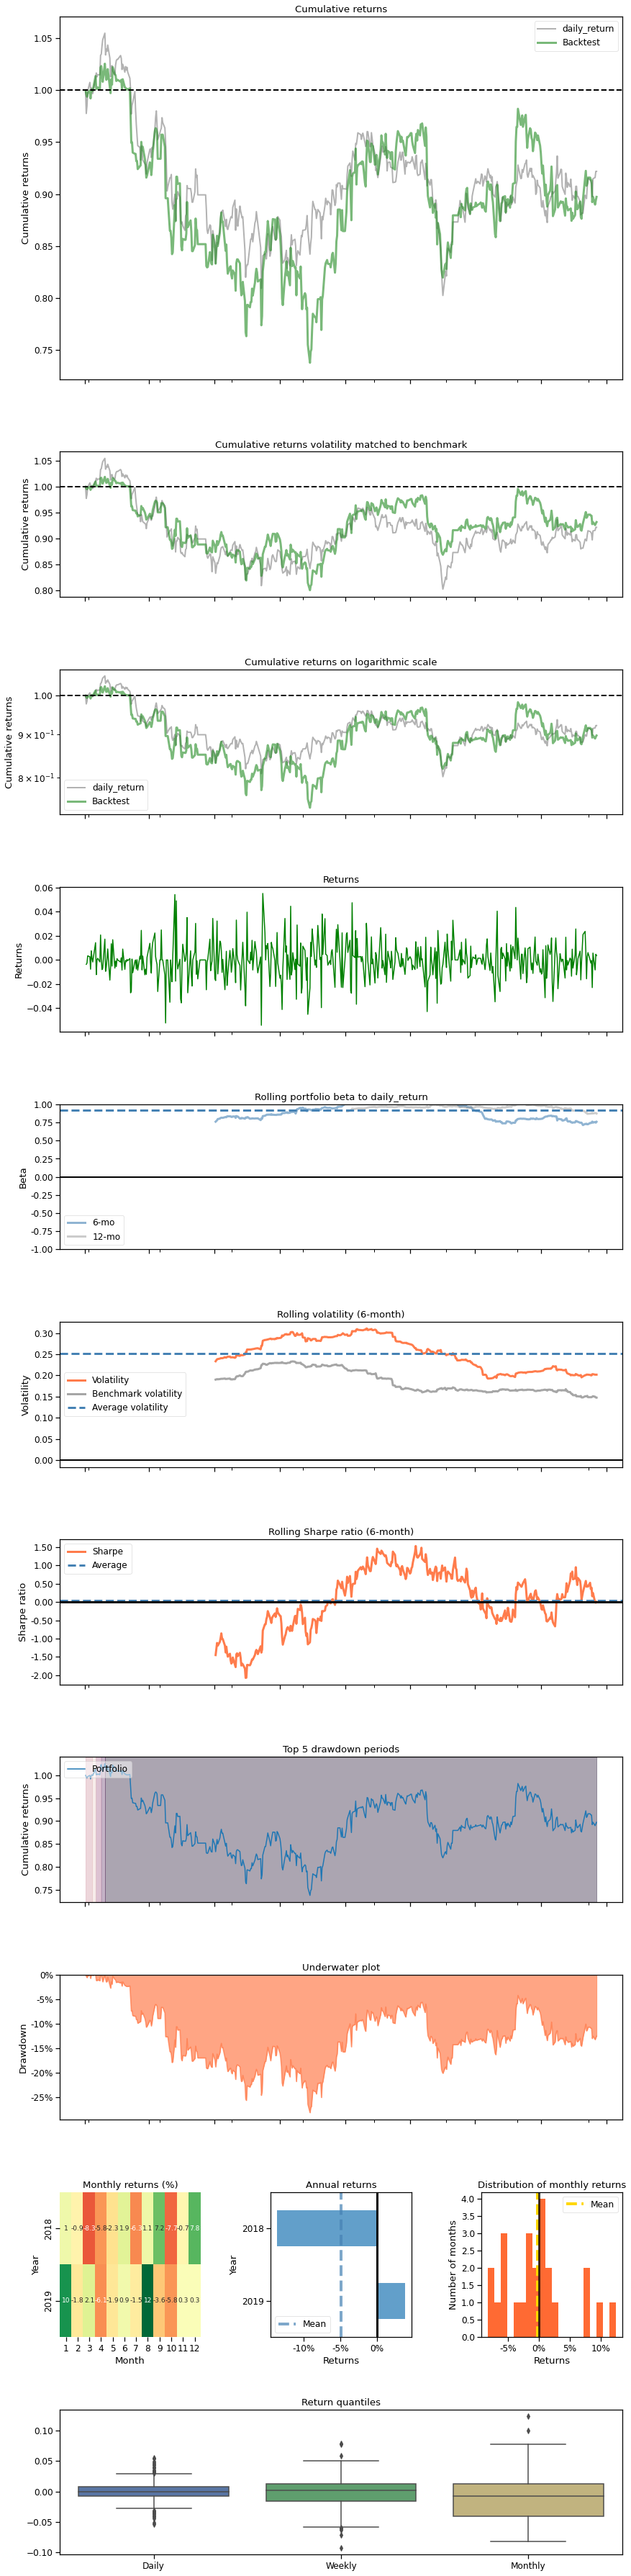

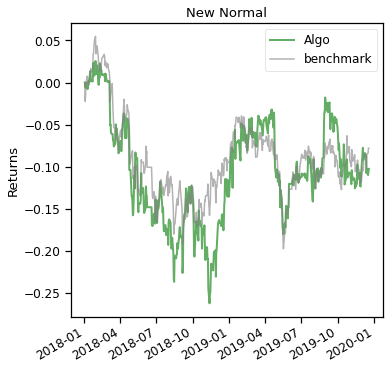

In [143]:
print("===========A2C Compare to JII===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
# JII: ^JKII
backtest_plot(df_account_value_a2c, 
             baseline_ticker = '^JKII', 
             baseline_start = df_account_value_a2c.loc[0,'date'],
             baseline_end = df_account_value_a2c.loc[len(df_account_value_a2c)-1,'date'])

###8.2.2. Agen PPO

===========PPO Compare to JII===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (478, 8)


Start date,2018-01-02
End date,2019-12-18
Total months,23
,Backtest
Annual return,15.421%
Cumulative returns,32.54%
Annual volatility,26.08%
Sharpe ratio,0.68
Calmar ratio,0.51
Stability,0.30
Max drawdown,-30.068%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,30.07,2018-02-01,2018-09-13,2019-04-18,316
1,15.50,2019-05-01,2019-05-17,2019-08-27,85
2,9.87,2019-09-11,2019-11-04,2019-11-19,50
3,2.29,2019-11-19,2019-11-22,2019-11-25,5
4,1.62,2019-12-03,2019-12-05,2019-12-06,4


Stress Events,mean,min,max
New Normal,0.07%,-6.94%,6.59%


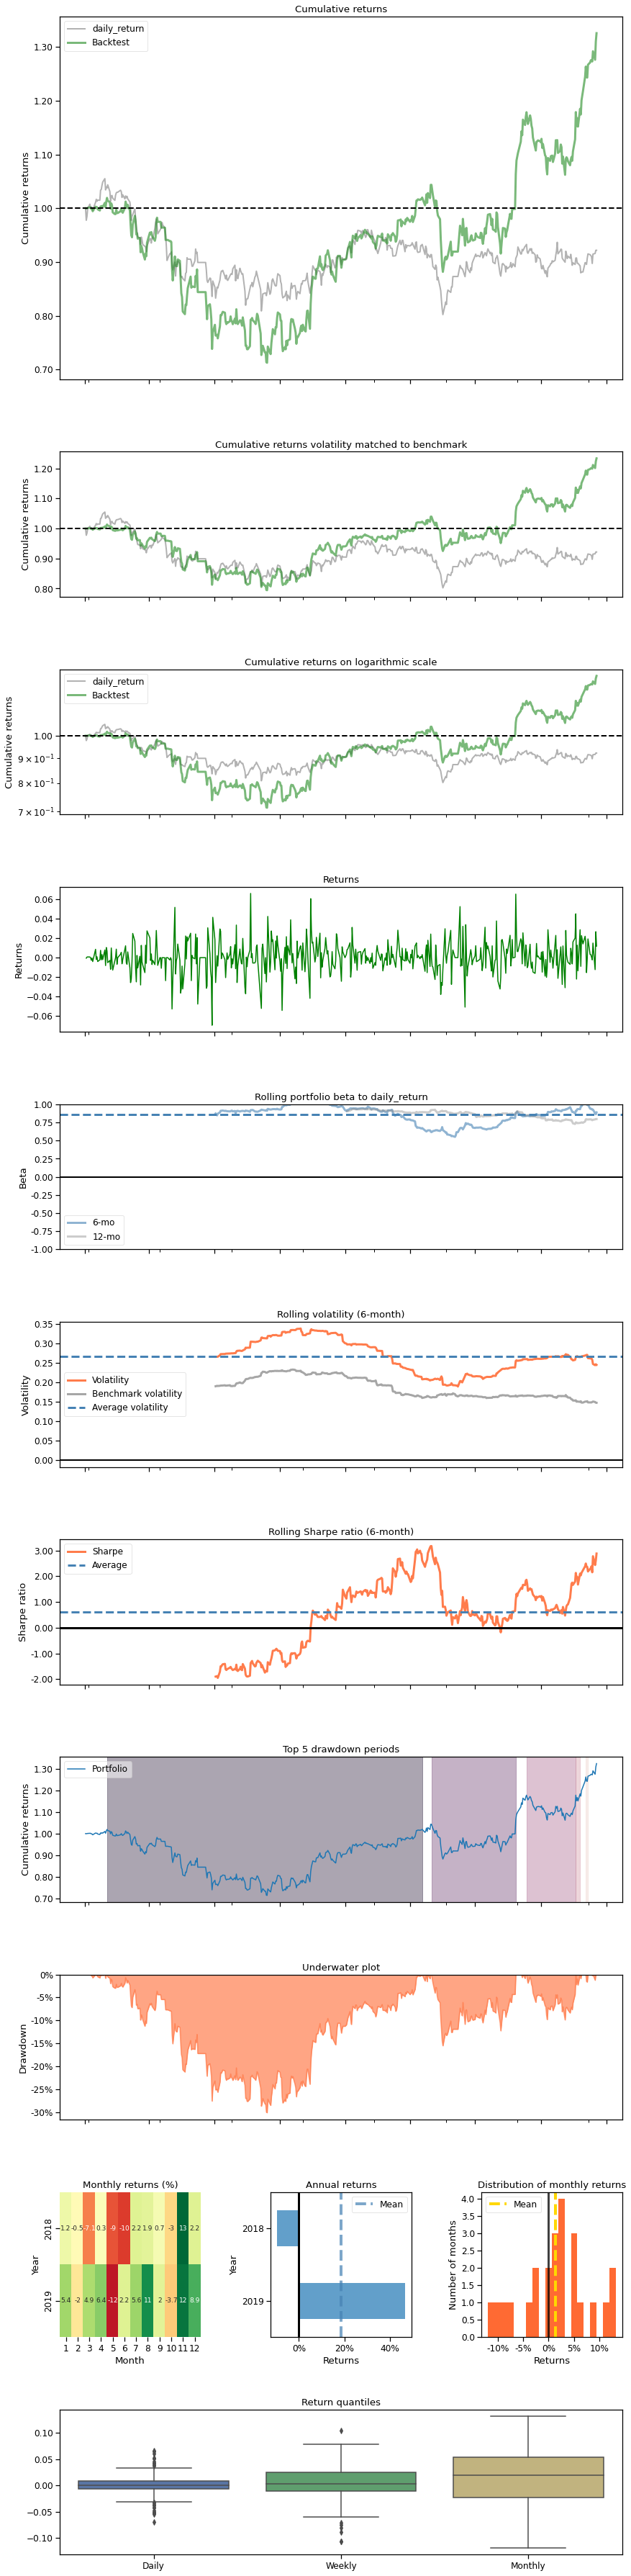

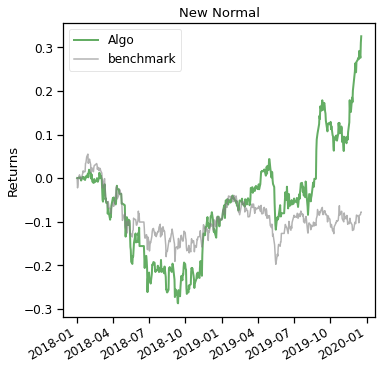

In [144]:
print("===========PPO Compare to JII===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
# JII: ^JKII
backtest_plot(df_account_value_ppo, 
             baseline_ticker = '^JKII', 
             baseline_start = df_account_value_ppo.loc[0,'date'],
             baseline_end = df_account_value_ppo.loc[len(df_account_value_ppo)-1,'date'])

###8.2.3. Agen TD3

===========TD3 Compare to JII===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (478, 8)


Start date,2018-01-02
End date,2019-12-18
Total months,23
,Backtest
Annual return,-18.745%
Cumulative returns,-33.486%
Annual volatility,33.939%
Sharpe ratio,-0.44
Calmar ratio,-0.37
Stability,0.84
Max drawdown,-50.773%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,50.77,2018-03-13,2019-10-10,NaT,NaN
1,1.43,2018-02-27,2018-03-06,2018-03-13,11
2,1.15,2018-02-05,2018-02-23,2018-02-27,17
3,0.15,2018-01-05,2018-01-12,2018-01-16,8
4,0.14,2018-01-29,2018-01-30,2018-01-31,3


Stress Events,mean,min,max
New Normal,-0.06%,-5.88%,8.77%


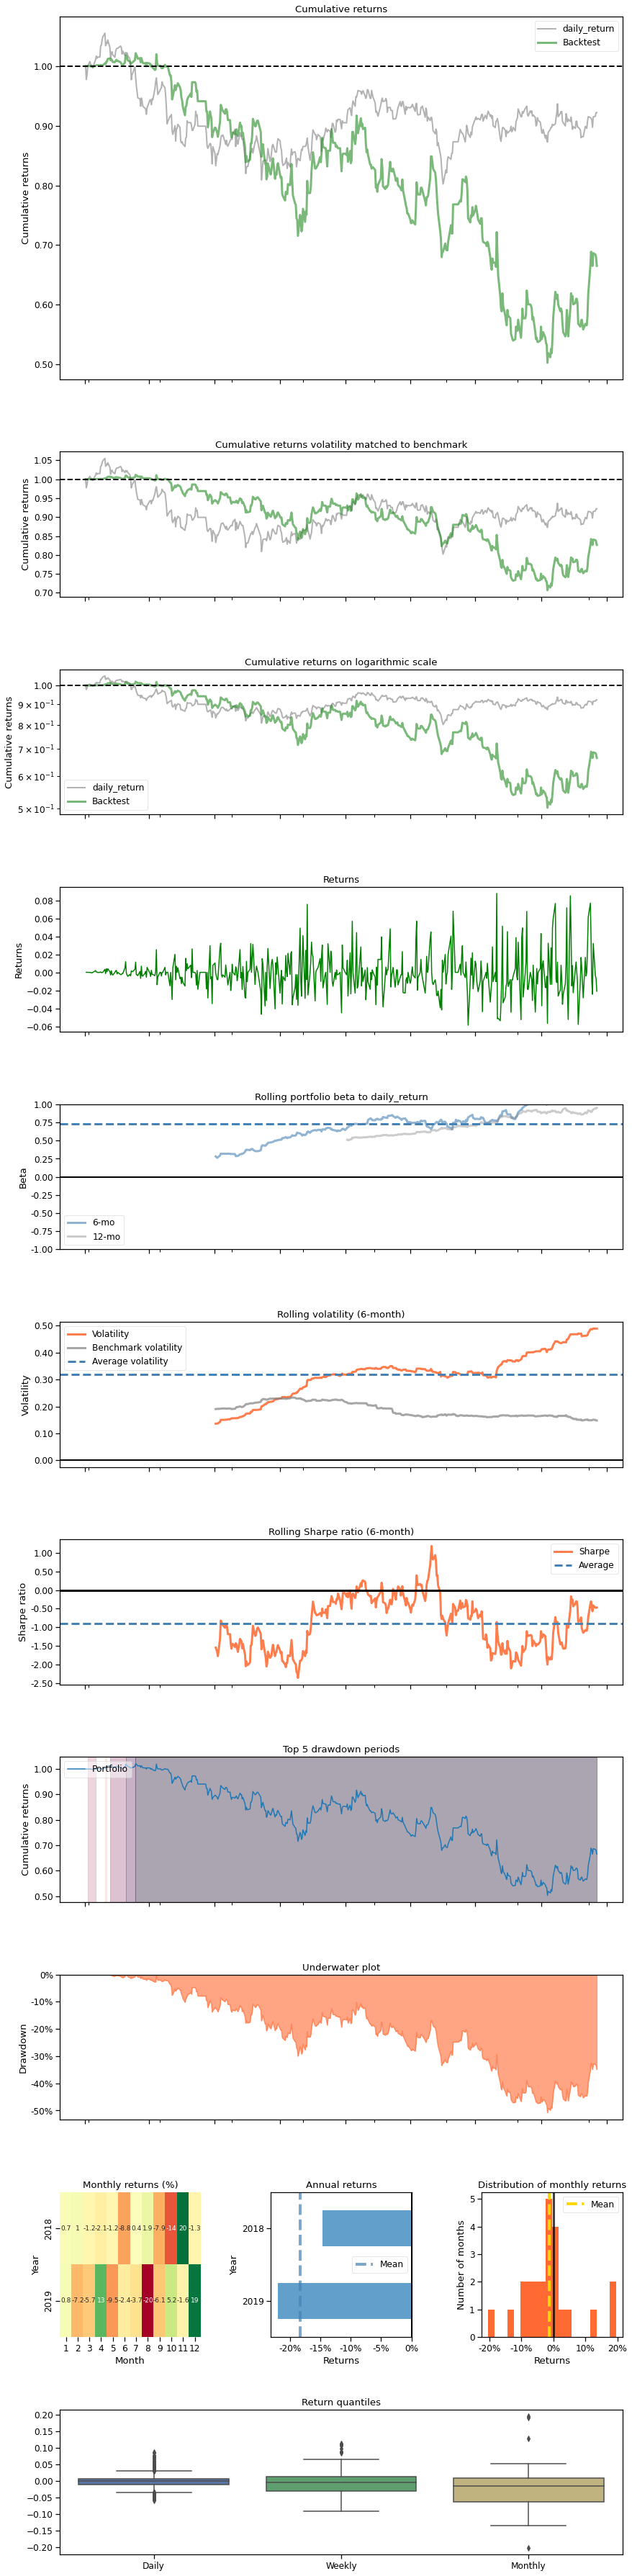

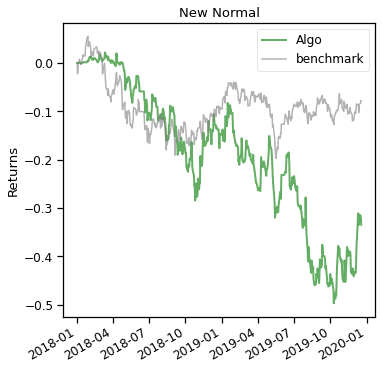

In [145]:
print("===========TD3 Compare to JII===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
# JII: ^JKII
backtest_plot(df_account_value_td3, 
             baseline_ticker = '^JKII', 
             baseline_start = df_account_value_td3.loc[0,'date'],
             baseline_end = df_account_value_td3.loc[len(df_account_value_td3)-1,'date'])

###8.2.4. Agen SAC

============SAC Compare to JII===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (478, 8)


Start date,2018-01-02
End date,2019-12-18
Total months,23
,Backtest
Annual return,-5.251%
Cumulative returns,-10.054%
Annual volatility,22.559%
Sharpe ratio,-0.13
Calmar ratio,-0.19
Stability,0.00
Max drawdown,-27.257%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,27.26,2018-01-29,2018-11-12,NaT,NaN
1,1.46,2018-01-24,2018-01-26,2018-01-29,4
2,1.35,2018-01-16,2018-01-22,2018-01-23,6
3,0.80,2018-01-08,2018-01-09,2018-01-16,7
4,0.55,2018-01-02,2018-01-04,2018-01-08,5


Stress Events,mean,min,max
New Normal,-0.01%,-5.36%,5.53%


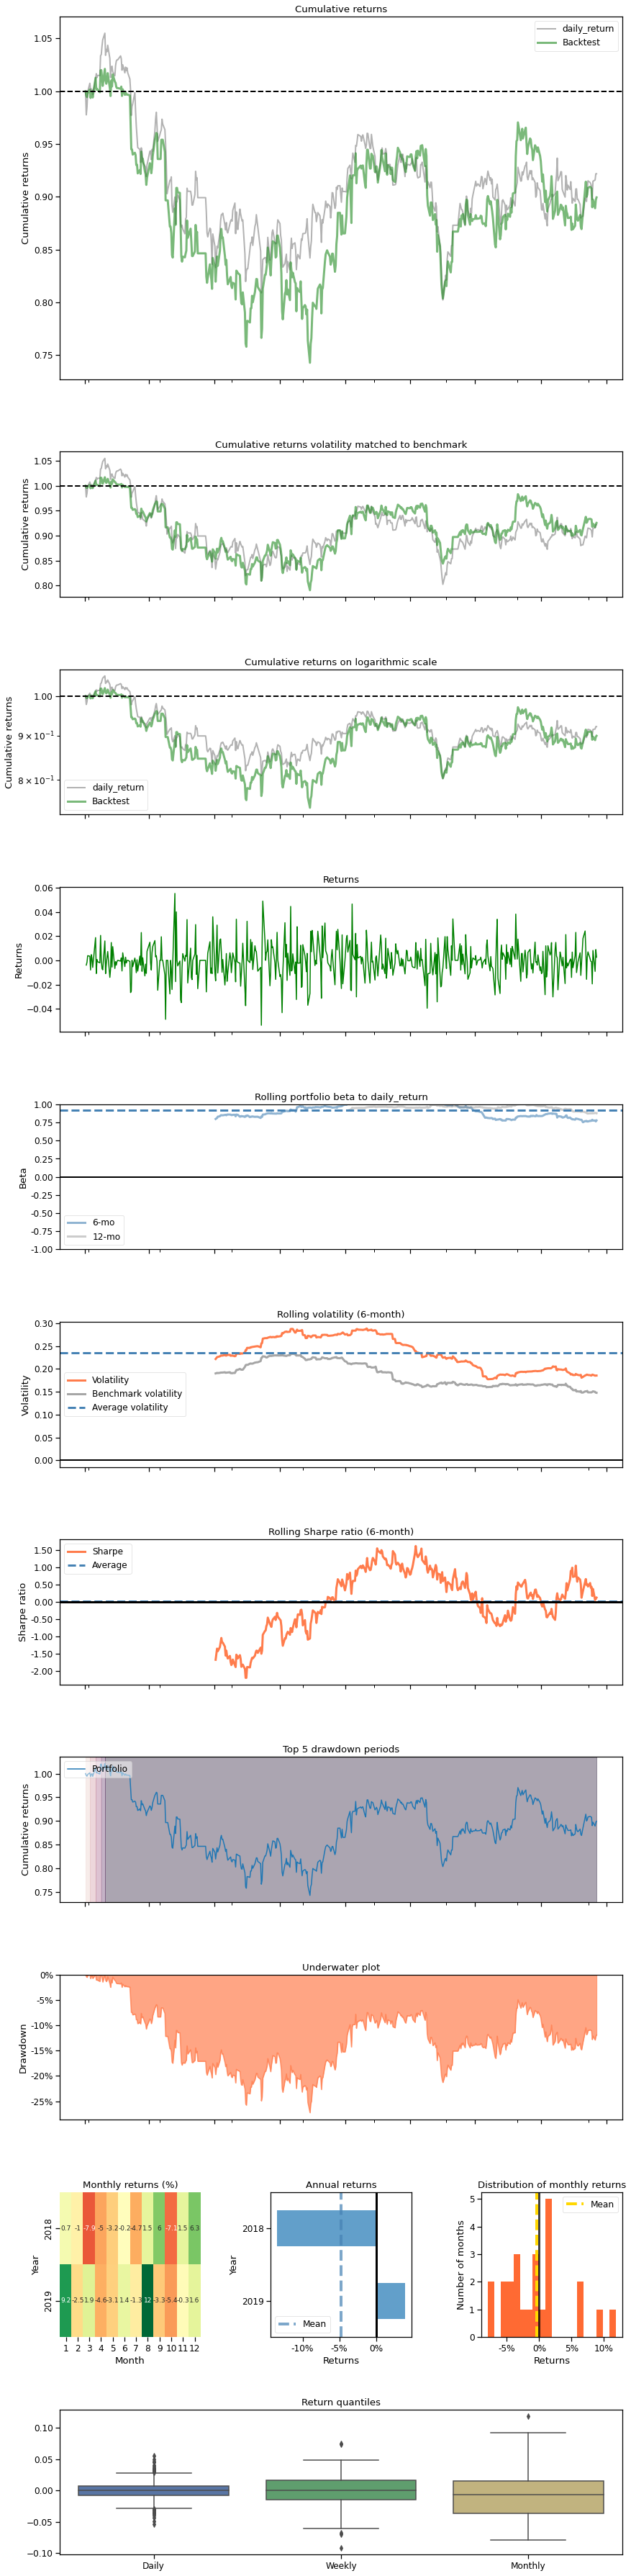

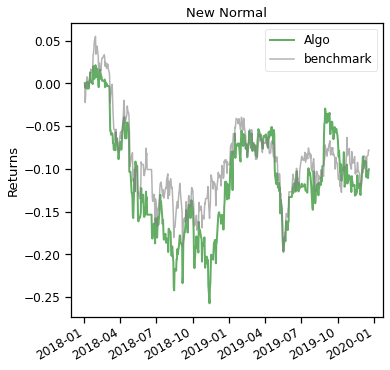

In [146]:
print("============SAC Compare to JII===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
# JII: ^JKII
backtest_plot(df_account_value_sac, 
             baseline_ticker = '^JKII', 
             baseline_start = df_account_value_sac.loc[0,'date'],
             baseline_end = df_account_value_sac.loc[len(df_account_value_sac)-1,'date'])

###8.2.5. Agen DDPG

===========DDPG Compare to JII===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (478, 8)


Start date,2018-01-02
End date,2019-12-18
Total months,23
,Backtest
Annual return,-11.682%
Cumulative returns,-21.653%
Annual volatility,24.589%
Sharpe ratio,-0.38
Calmar ratio,-0.41
Stability,0.23
Max drawdown,-28.475%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,28.48,2018-01-24,2018-11-12,NaT,NaN
1,1.11,2018-01-16,2018-01-17,2018-01-23,6
2,0.81,2018-01-08,2018-01-09,2018-01-11,4
3,0.55,2018-01-02,2018-01-04,2018-01-08,5
4,0.20,2018-01-11,2018-01-12,2018-01-16,4


Stress Events,mean,min,max
New Normal,-0.04%,-5.44%,5.60%


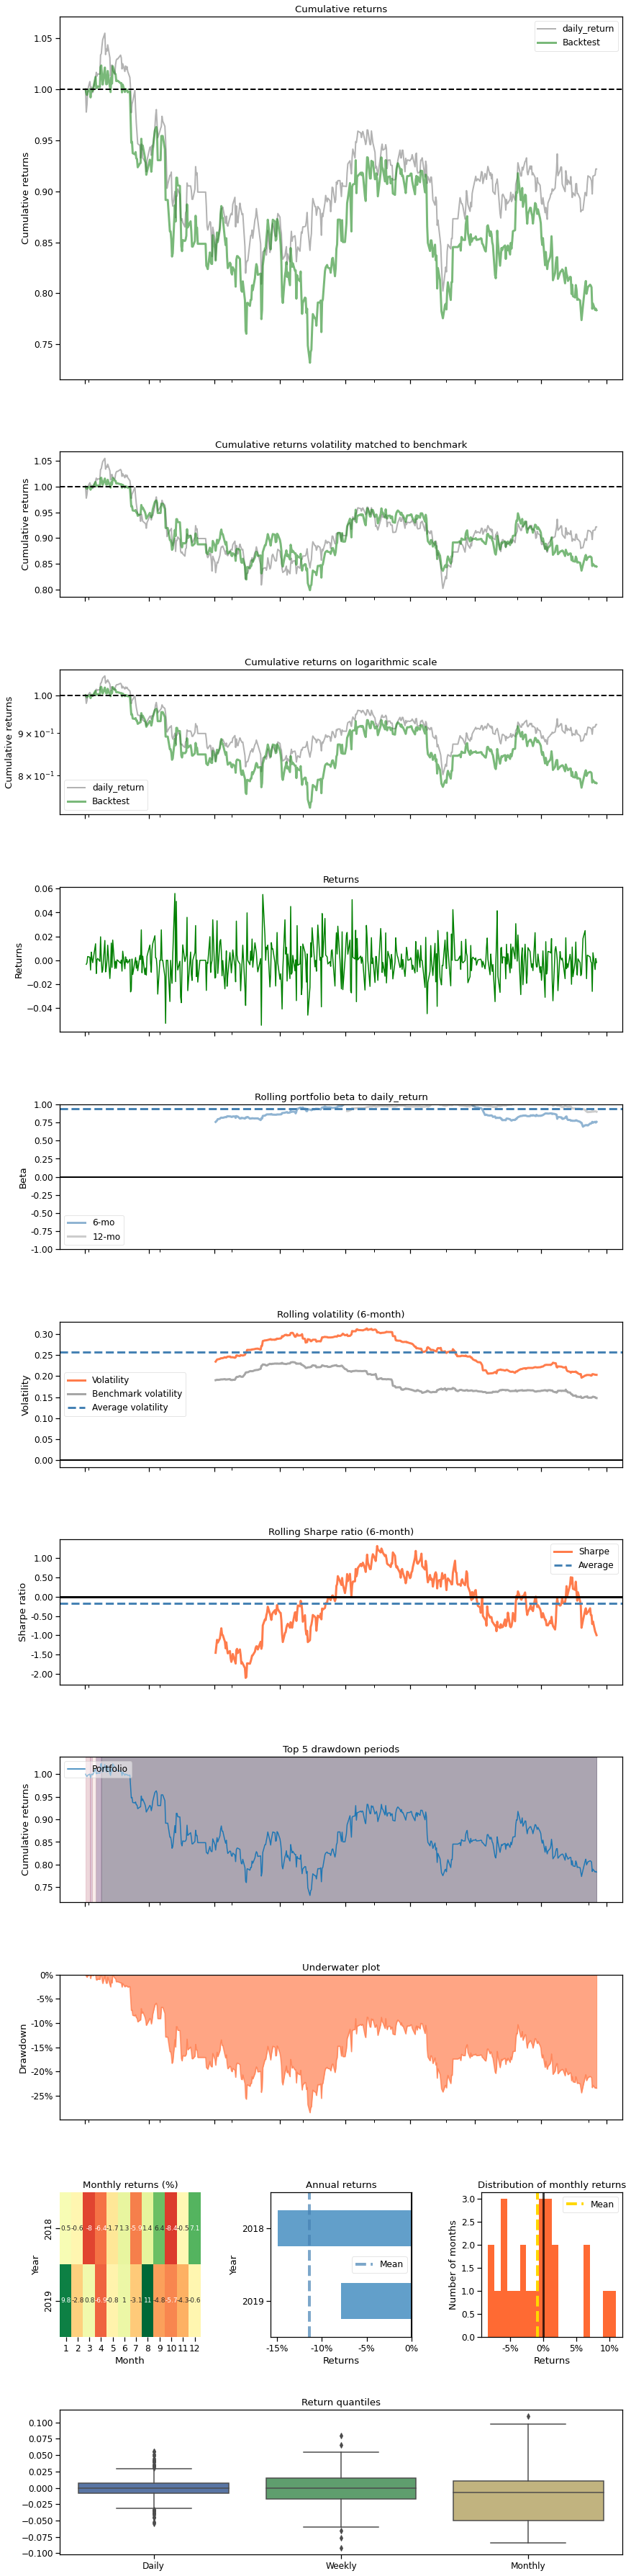

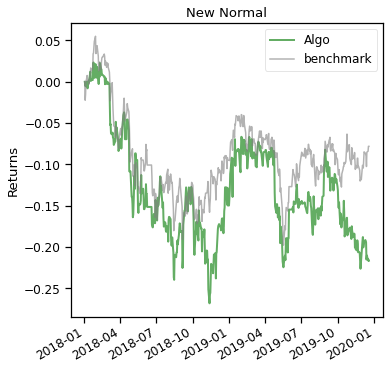

In [147]:
print("===========DDPG Compare to JII===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
# JII: ^JKII
backtest_plot(df_account_value_ddpg, 
             baseline_ticker = '^JKII', 
             baseline_start = df_account_value_ddpg.loc[0,'date'],
             baseline_end = df_account_value_ddpg.loc[len(df_account_value_ddpg)-1,'date'])